# Data extraction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

In [4]:
df = pd.read_csv("../data/creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

## Train/Test split

In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [7]:
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=11, test_size=0.2, stratify=y)

# Random forest

In [8]:
model = RandomForestClassifier(random_state=11)

params= {
    'class_weight': [
        {0: 1, 1: 25},
        {0: 1, 1: 50},
        {0: 1, 1: 75}
    ],
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]

}

In [9]:
cv_method = StratifiedKFold(n_splits= 5, shuffle=True, random_state=11)

random_search= RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=20,
    scoring= ['f1', 'recall'],
    refit= 'f1',
    cv = cv_method,
    verbose = 2,
    random_state=11,
    n_jobs= -1
)

In [10]:
print("randomized search...")
random_search.fit(X_train, y_train)

randomized search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestC...ndom_state=11)
,param_distributions,"{'class_weight': [{0: 1, 1: 25}, {0: 1, 1: 50}, ...], 'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,n_iter,20
,scoring,"['f1', 'recall']"
,n_jobs,-1
,refit,'f1'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,11
,error_score,nan


In [11]:
print("Best parameters found by GridSearchCV:")
print(random_search.best_params_)

Best parameters found by GridSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': {0: 1, 1: 25}}


In [15]:
best_model = random_search.best_estimator_
print(best_model)
y_pred = best_model.predict(X_test)

RandomForestClassifier(class_weight={0: 1, 1: 25}, min_samples_split=5,
                       n_estimators=200, random_state=11)


# Feature importance

In [ ]:
importances = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Evaluation

In [13]:
print("\nClassification Report for the Best Model:")
print(classification_report(y_test, y_pred))


Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [16]:
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold= roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

ROC-AUC: 0.9670617613956107


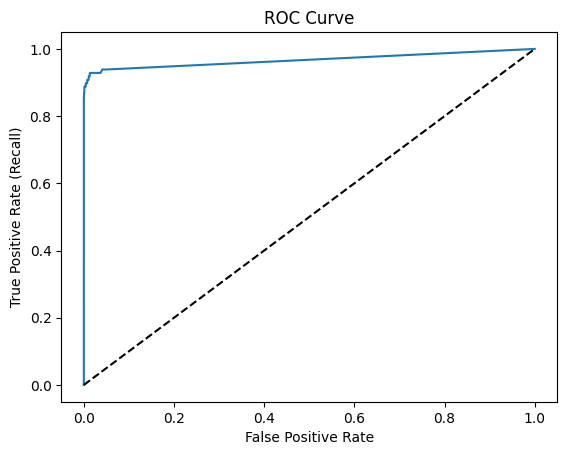

In [17]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.show()

# Report

model achieved a reasonable Recall **while** maintaining a rather high precision. Logistic regression was used as a baseline model earlier with also a reasonable recall but very low precision wich is performatively expensive.
Due to log-reg's linear decision boundary and sensitivity to class imbalance, random forest is considered a better model for catching fraud.